<a href="https://colab.research.google.com/github/Dandhalf/Practice/blob/main/tensorflow_%EA%B8%B0%EC%B4%8804_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5_cat_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 전이학습부터는 GPU 문제로 코랩에서 수행

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-09-02 06:25:56--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.211.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   333MB/s    in 0.2s    

2022-09-02 06:25:56 (333 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import shutil

if os.path.exists('./content/cats_and_dogs_filtered/'):
  shutil.rmtree('./content/cats_and_dogs_filtered/')
  print('/content/cats_and_dogs_filtered/ is removed !!!')

In [4]:
# 압축파일 풀기

import zipfile
with zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r') as target_file:
  target_file.extractall('/content/cats_and_dogs_filtered/')

### 모델 구축

In [5]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

base_model = Xception(weights = 'imagenet', include_top = False, input_shape = (IMG_WIDTH,IMG_HEIGHT,3 ))

model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())

# user - defined classifier
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation = 'softmax'))

model.summary()


83697664/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20,894,298
Trainable params: 20,839,770
Non

### ImageDataGenerator 정의

In [6]:
train_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'
valid_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 10, width_shift_range = 0.1,
                                    height_shift_range = 0.1, shear_range = 0.1, zoom_range = 0.1)

valid_data_gen = ImageDataGenerator(rescale = 1./255)

In [7]:
train_data = train_data_gen.flow_from_directory(train_dir, batch_size = 32, 
                                                color_mode = 'rgb', shuffle = True, class_mode = 'categorical',
                                                target_size = (IMG_WIDTH,IMG_HEIGHT))

valid_data = valid_data_gen.flow_from_directory(valid_dir, batch_size = 32, 
                                                color_mode = 'rgb', shuffle = True, class_mode = 'categorical',
                                                target_size = (IMG_WIDTH,IMG_HEIGHT))

# class_mode = 'categorical'
# one-hot encoding으로 정답 나올 거임

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
# 정답 확인
# .class_indices 이용하여 문자열로 표시되는 데이터의 정답이 어떤 숫자로 매칭되어 있는지 확인
print(train_data.class_indices.items())
print(valid_data.class_indices.items())

dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])


In [9]:
print(train_data.class_indices)

{'cats': 0, 'dogs': 1}


### 모델 컴파일 및 학습

In [10]:
# 모델 컴파일
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(2e-5), metrics = ['accuracy'])

In [11]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
save_file_name = './cat_and_dog_filtered_Xception_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name, monitor = 'val_loss', verbose = 1, 
                            save_best_only = True, mode = 'auto')

earlystopping = EarlyStopping(monitor = 'val_loss', patience = 5)


In [14]:
# 모델 학습
hist = model.fit(train_data, epochs = 30, validation_data = valid_data, callbacks = [checkpoint, earlystopping])

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.4916 - accuracy: 0.7995
Epoch 1: val_loss improved from inf to 0.12297, saving model to ./cat_and_dog_filtered_Xception_Colab.h5
63/63 [==============================] - 65s 750ms/step - loss: 0.4916 - accuracy: 0.7995 - val_loss: 0.1230 - val_accuracy: 0.9760
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9610
Epoch 2: val_loss improved from 0.12297 to 0.05051, saving model to ./cat_and_dog_filtered_Xception_Colab.h5
63/63 [==============================] - 44s 694ms/step - loss: 0.1907 - accuracy: 0.9610 - val_loss: 0.0505 - val_accuracy: 0.9830
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9775
Epoch 3: val_loss improved from 0.05051 to 0.03899, saving model to ./cat_and_dog_filtered_Xception_Colab.h5
63/63 [==============================] - 45s 708ms/step - loss: 0.0985 - accuracy: 0.9775 - val_loss: 0.0390 - val_accuracy: 0.9850

### 손실 및 정확도 

In [13]:
import matplotlib.pyplot as plt

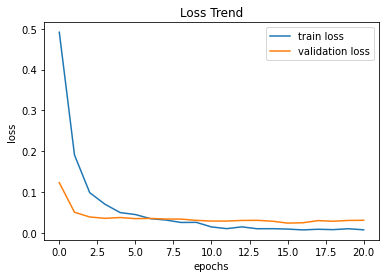

In [15]:
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid

plt.plot(hist.history['loss'], label = 'train loss')
plt.plot(hist.history['val_loss'], label = 'validation loss')

plt.legend(loc = 'best')

plt.show()

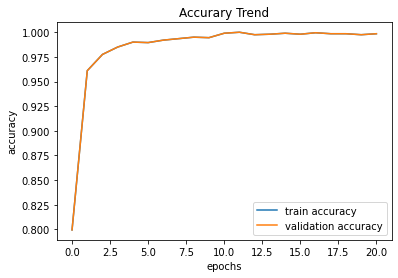

In [16]:
plt.title('Accurary Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid

plt.plot(hist.history['accuracy'], label = 'train accuracy')
plt.plot(hist.history['accuracy'], label = 'validation accuracy')

plt.legend(loc = 'best')

plt.show()

In [19]:
### 테스트 데이터 로드 및 예측

In [21]:
from google.colab import files 

uploaded = files.upload()

# 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving animal.zip to animal.zip
User uploaded file "animal.zip" with length 371909 bytes


In [22]:
! mkdir animal
! unzip animal.zip -d ./animal

Archive:  animal.zip
  inflating: ./animal/cat01.jpg      
  inflating: ./animal/cat02.jpg      
  inflating: ./animal/cat03.jpg      
  inflating: ./animal/dog01.jpg      
  inflating: ./animal/dog02.jpg      
  inflating: ./animal/dog03.jpg      


#### tip
- glob.glob() : 디렉토리 내 파일, 폴더 정보 리스트로 반환
- https://jimmy-ai.tistory.com/197
- https://wikidocs.net/83

- cv2.imread(  , cv2.IMREAD_COLOR) : 컬러로 읽기


In [34]:
import cv2
import glob

test_img_list = []

# glob.glob() : 디렉토리 내 파일, 폴더 정보 리스트로 반환
test_img_name_list = glob.glob('animal/*')

# 테스트 이미지 파일 로드 및 전처리
for i in range(len(test_img_name_list)):

  src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR) # 컬로로 읽겠음
  src_img = cv2.resize(src_img, dsize = (IMG_WIDTH,IMG_HEIGHT)) # 사이즈 재조정

  dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB) # BGR -> RGV

  dst_img = dst_img / 255.0

  test_img_list.append(dst_img)

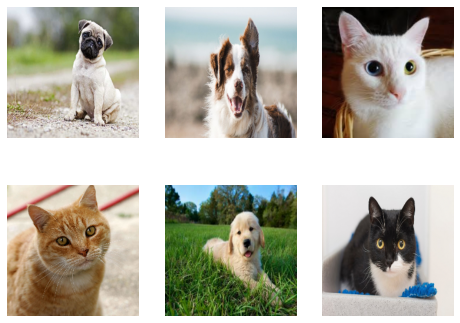

In [26]:
plt.figure(figsize = (8,6))

for i in range(len(test_img_list)):
  plt.subplot(2,3, i + 1 )
  plt.axis('off')
  plt.imshow(test_img_list[i])

plt.show()


In [27]:
for i in range(len(test_img_list)):
  print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [29]:
import numpy as np

# batch 차원 추가하여 predict 실행 (batch_size, width, height, channel)
pred = model.predict(np.array(test_img_list))

class_name = ['cat', 'dog'] #ImageDataGenerator 에서 cat = 0, dog = 1

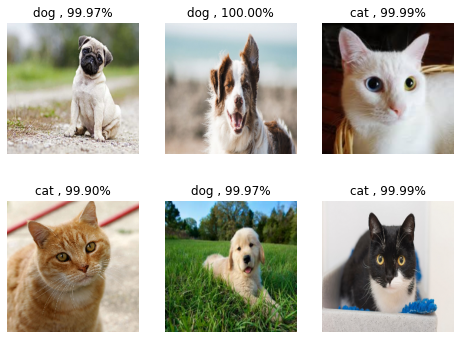

In [33]:
plt.figure(figsize = (8,6))

for i in range(len(pred)):
  plt.subplot(2, 3, i + 1 )
  prediction = str(class_name[np.argmax(pred[i])])
  proba = '{0:0.2f}'.format(100*max(pred[i]))
  title_str = prediction + ' , ' + proba + '%'

  plt.axis('off')
  plt.title(title_str)
  plt.imshow(test_img_list[i])

plt.show()